In [1]:
!pip install -U accelerate
!pip install -U transformers

In [2]:
from transformers import BertForSequenceClassification, BertTokenizer, BertConfig, BertModel
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics.cluster import contingency_matrix

import shutil
import torch
import json
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
np.random.seed(42)

In [3]:
import pandas as pd
df = pd.read_csv("nancy_determinants_grouped.csv")


In [4]:
df.rename(columns = {"Answer (English)": "FQText"}, inplace=True)

df.drop(['Déterminant', 'C', 'C\'', 'C\'F',
       'CF', 'CF\'', 'CLOB', 'CLOBF', 'E', 'EF', 'F', 'FC', 'FC\'', 'FCLOB',
       'FE', 'K', 'KAN', 'KOB', 'KP', 'Réponse (French)'], axis=1, inplace=True)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   FQText            380 non-null    object
 1   color_sum         380 non-null    int64 
 2   threat_sum        380 non-null    int64 
 3   fading_sum        380 non-null    int64 
 4   form_sum          380 non-null    int64 
 5   kinesthetics_sum  380 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 17.9+ KB


In [6]:
df.columns

Index(['FQText', 'color_sum', 'threat_sum', 'fading_sum', 'form_sum',
       'kinesthetics_sum'],
      dtype='object')

In [7]:
import numpy as np

In [8]:
df = df.astype({'color_sum': np.float32, 'threat_sum': np.float32, 'fading_sum': np.float32, 'form_sum': np.float32,
       'kinesthetics_sum': np.float32})

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   FQText            380 non-null    object 
 1   color_sum         380 non-null    float32
 2   threat_sum        380 non-null    float32
 3   fading_sum        380 non-null    float32
 4   form_sum          380 non-null    float32
 5   kinesthetics_sum  380 non-null    float32
dtypes: float32(5), object(1)
memory usage: 10.5+ KB


In [10]:
def pre_process_data(df, test_proportion, train_size):

    size_df = df.shape[0]
    df = shuffle(df)
    X = df[["FQText"]]
    y = df.drop(["FQText"], axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_proportion, shuffle=True, random_state=42)

    df_train = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
    df_test = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)
    df_labels = list(y.columns)

    print(df_labels)

    train_df = df_train.sample(frac=train_size, random_state=42).reset_index(drop=True)
    val_df = df_train.drop(train_df.index).reset_index(drop=True)

    print("Total amount of data: {}".format(size_df))
    print("Number of rows used to TRAIN: {}".format(train_df.shape[0]))
    print("Number of rows used to VALIDATE: {}".format(val_df.shape[0]))
    print("Number of rows used to TEST: {}".format(df_test.shape[0]))

    return train_df, val_df, df_test, df_labels

<Axes: ylabel='Frequency'>

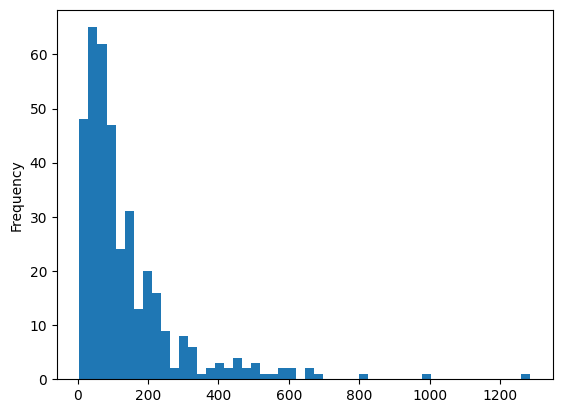

In [11]:
df["FQText"].str.len().plot.hist(bins=50)

In [25]:
MAX_LEN = 256

In [13]:
import torch
from transformers import DistilBertTokenizer, AutoTokenizer
from transformers import DistilBertForSequenceClassification, AutoModelForSequenceClassification

from transformers import BertForSequenceClassification, BertTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset

In [14]:
train_df, val_df, df_test, df_labels = pre_process_data(df, 0.1, 0.8)

['color_sum', 'threat_sum', 'fading_sum', 'form_sum', 'kinesthetics_sum']
Total amount of data: 380
Number of rows used to TRAIN: 274
Number of rows used to VALIDATE: 68
Number of rows used to TEST: 38


In [15]:
checkpoint = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(checkpoint)
model = BertForSequenceClassification.from_pretrained(checkpoint, num_labels=len(df_labels),
                                                            problem_type="multi_label_classification")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# class CustomDataset(Dataset):
#   def __init__(self, texts, labels, tokenizer, max_len=128):
#     self.texts = texts
#     self.labels = labels
#     self.tokenizer = tokenizer
#     self.max_len = max_len

#   def __len__(self):
#     return len(self.texts)

#   def __getitem__(self, idx):
#     text = str(self.texts[idx])
#     label = torch.tensor(self.labels[idx])

#     encoding = self.tokenizer(text, truncation=True, padding="max_length", max_length=self.max_len, return_tensors='pt')

#     return {
#         'input_ids': encoding['input_ids'].flatten(),
#         'attention_mask': encoding['attention_mask'].flatten(),
#         'labels': label
#     }

In [26]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.df = df
        self.texts = df['FQText']
        self.targets = self.df[df_labels].values
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = str(self.texts[index])
        label = torch.tensor(self.targets[index])

        encoding = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True, # do we actually need special tokens ??
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'  # pytorch tensors
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index])
        }

In [27]:
train_dataset = CustomDataset(train_df, tokenizer, MAX_LEN)
val_dataset = CustomDataset(val_df, tokenizer, MAX_LEN)

In [19]:
# train_dataset[0]

In [28]:
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score, hamming_loss
from transformers import EvalPrediction
import torch


def multi_labels_metrics(predictions, targets, threshold=0.5): # mess with threshold
  sigmoid = torch.nn.Sigmoid()
  probs = sigmoid(torch.Tensor(predictions)) #mapply activation function in the raw values

  y_pred = np.zeros(probs.shape)
  y_pred[np.where(probs>=threshold)] = 1
  y_true = targets

  f1 = f1_score(y_true, y_pred, average = 'weighted')
  roc_auc = roc_auc_score(y_true, y_pred, average = 'weighted')
  hamming = hamming_loss(y_true, y_pred)

  metrics = {
      "roc_auc": roc_auc,       # special multilabel metrics
      "hamming_loss": hamming,  # special multilabel metrics
      "f1": f1
  }

  return metrics

def compute_metrics(p:EvalPrediction):
  preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions

  result = multi_labels_metrics(predictions=preds,
                                targets=p.label_ids)

  return result

In [29]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    learning_rate=1e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    output_dir = './results',
    num_train_epochs=3,

)

trainer = Trainer(model=model,
                  args=args,
                  train_dataset = train_dataset,
                  eval_dataset = val_dataset,
                  compute_metrics=compute_metrics)

In [30]:
trainer.train()

ValueError: The model did not return a loss from the inputs, only the following keys: logits. For reference, the inputs it received are input_ids,attention_mask,token_type_ids.

In [ ]:
trainer.evaluate()